The work in this notebook is based on:
- https://github.com/pierremtb/PINNs-TF2.0
- https://github.com/janblechschmidt/PDEsByNNs

# Approximation and parameter identification of an Ecological Diffusion Equation (1).

In this notebook we find an approximated solution of the following PDE where we simultaneously identify parameters in the system. We consider the two-dimensional EDE equation on the spatial domain $\mathcal{D} = [0, 1] \times [0, 1]$ and temporal domain $\mathcal{T} = [0,3]$.

$$
\begin{aligned}
    \frac{\partial}{\partial t} u (t,x,y) - \nabla^2 [\mu(x,y,t) u(t,x,y)] - \lambda(x,y,t) u(t,x,y) (1 - u(t,x,y)) &= 0, \quad &&\quad (t,x,y) \in (0,3] \times (0, 1) \times (0, 1),\\
   u(0, x, y) &= f_0(x,y),                 \quad &&\quad x, y \in [0,1] \times [0, 1],\\
   u(t, 0, y) = u(t,1, y) = u(t, x, 0) = u(t, x, 1) &= 0,              \quad &&\quad t \in (0,3] \text{ and } x, y \in [0,1] \times [0, 1].
\end{aligned}
$$
where the initial condition is specified by
$$
f_0(x,y) = \{ 1+ \exp(-\kappa_0) \}^{-1} \exp \bigg[ - \frac{ (x-0.5)^2+ (y-0.5)^2  }{ (2\times \sigma^2) } \bigg].
$$
The log-diffusion and log-growth coefficients are
$$
\begin{aligned}
\log [\mu(x,y,t)] &= \alpha_0 + \alpha_1 \times h_1(x,y) \\
\log [\lambda(x,y,t)] &= \gamma_0 + \gamma_1 \times h_1(x,y),
\end{aligned}
$$
respectively, with $h_1$ a covariate assumed to follow
$$
h_1(x,y) = \{ 1+ \exp(-2) \}^{-1} \exp \bigg[ - \frac{ (x-0.2)^2+ (y-0.2)^2  }{ (2\times 0.4^2) } \bigg].
$$
\
The real parameters are:
$$
\begin{aligned}
\kappa_0 &= 3, \\
\sigma &= 0.10, \\
\alpha_0 &= -10.0, \\
\alpha_1 &= -1.0, \\
\gamma_0 &= 0.10, \\
\gamma_1 &= 0.01.
\end{aligned}
$$
note that the initial maximum prevalence is $\{ 1+ \exp(-\kappa) \}^{-1} = 0.952.$

In [ ]:
# Import section
import tensorflow as tf 
#
import numpy as np
from sklearn.metrics import (
    mean_squared_error,
    balanced_accuracy_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    f1_score,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    precision_recall_curve,
    auc,
)
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow import keras
import itertools
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import norm
import tensorflow_probability as tfp
import pandas as pd
from scipy.stats import norm
from time import time
import tensorflow_probability as tfp
import scipy.optimize

# Set data type to float32
DTYPE = "float32"
tf.keras.backend.set_floatx(DTYPE)

In [ ]:
# Read the dataset with simulated process
df = pd.read_csv(
    "simulated_data_1.csv",
    index_col=None,
)
df = df.rename(columns={"x": "s1", "y": "s2", "t": "time", "u": "y"})
df.head()

time    s1    s2         y
0   0.0  0.44  0.10  0.000671
1   0.0  0.70  0.10  0.000555
2   0.0  0.28  0.46  0.077885
3   0.0  0.98  0.90  0.000013
4   0.0  0.76  0.44  0.018924

In [ ]:
# Select the positives in the dataset using the mean value per timepoint
times = df.time.unique()
df.loc[df.time == times[0], "y"] = np.round(
    1.0 * (df.loc[df.time == times[0], "y"] > np.mean(df.loc[df.time == times[0], "y"]))
)
df.loc[df.time == times[1], "y"] = np.round(
    1.0 * (df.loc[df.time == times[1], "y"] > np.mean(df.loc[df.time == times[1], "y"]))
)
df.loc[df.time == times[2], "y"] = np.round(
    1.0 * (df.loc[df.time == times[2], "y"] > np.mean(df.loc[df.time == times[2], "y"]))
)
df.loc[df.time == times[3], "y"] = np.round(
    1.0 * (df.loc[df.time == times[3], "y"] > np.mean(df.loc[df.time == times[3], "y"]))
)
df.loc[df.time == times[4], "y"] = np.round(
    1.0 * (df.loc[df.time == times[4], "y"] > np.mean(df.loc[df.time == times[4], "y"]))
)
df.loc[df.time == times[5], "y"] = np.round(
    1.0 * (df.loc[df.time == times[5], "y"] > np.mean(df.loc[df.time == times[5], "y"]))
)

In [ ]:
# Make some false negatives with 0.02 probability to add some noise to the data
df.loc[df.y == 1, "y"] = np.random.choice(
    [0, 1], df.loc[df.y == 1].shape[0], p=[0.02, 0.98]
)

In [ ]:
# Use only data after initial state
df_original = df[df.time > 0]
df_original.shape

(5000, 4)

In [ ]:
# Check positive/negative balance in dataset
df_original.y.value_counts()

y
0.0    3850
1.0    1150
Name: count, dtype: int64

<Axes: title={'center': 'Observed data at time 3.0'}, xlabel='s1', ylabel='s2'>

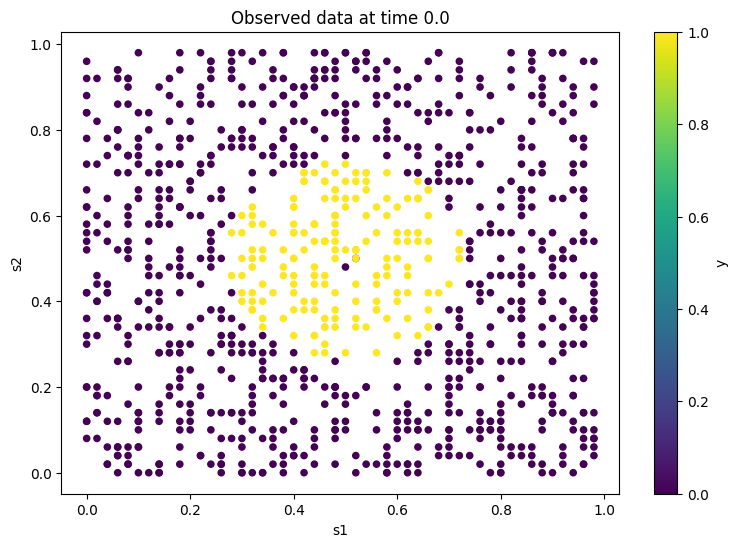

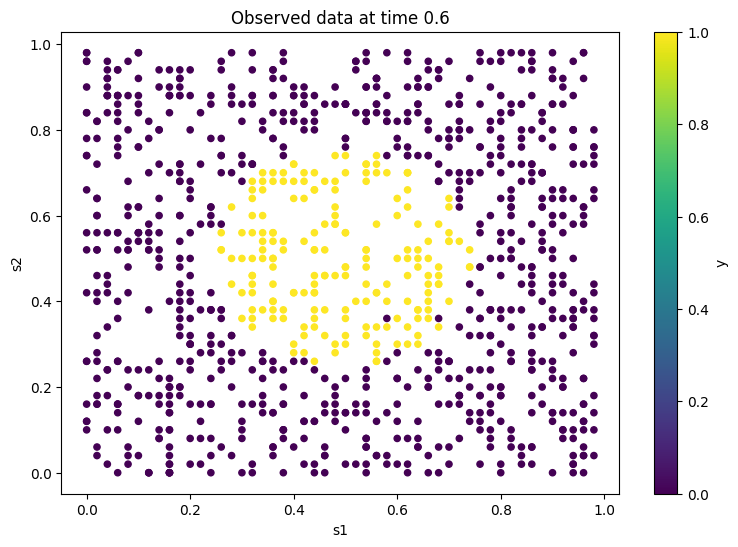

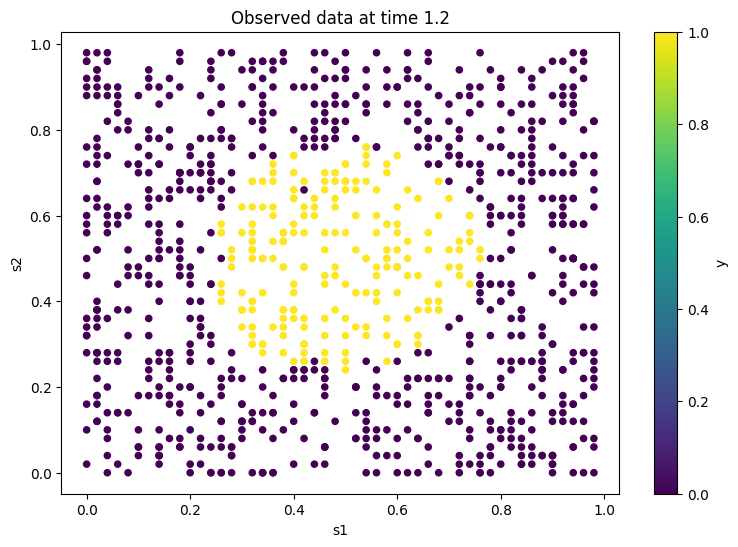

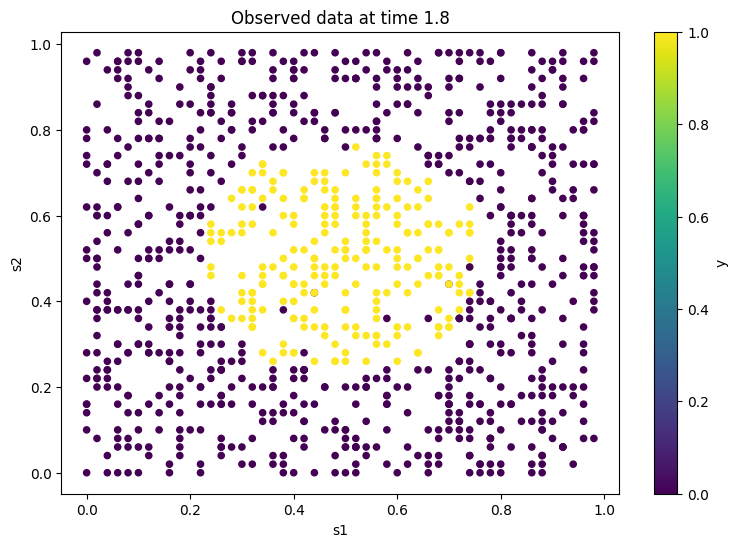

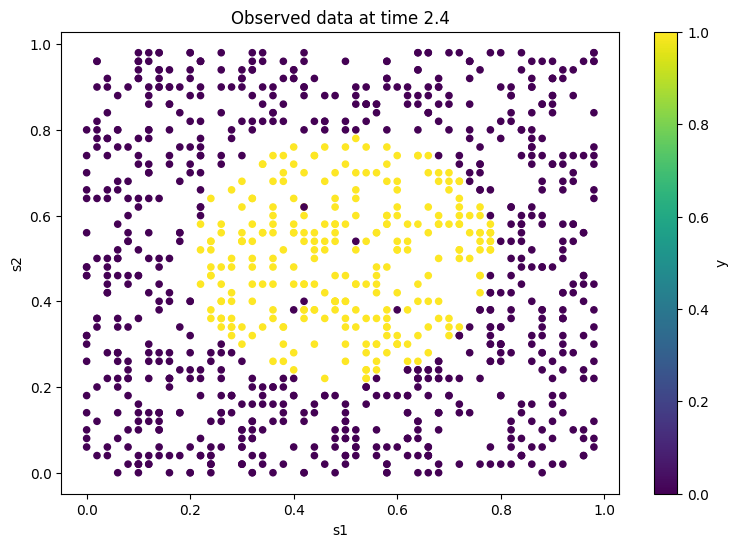

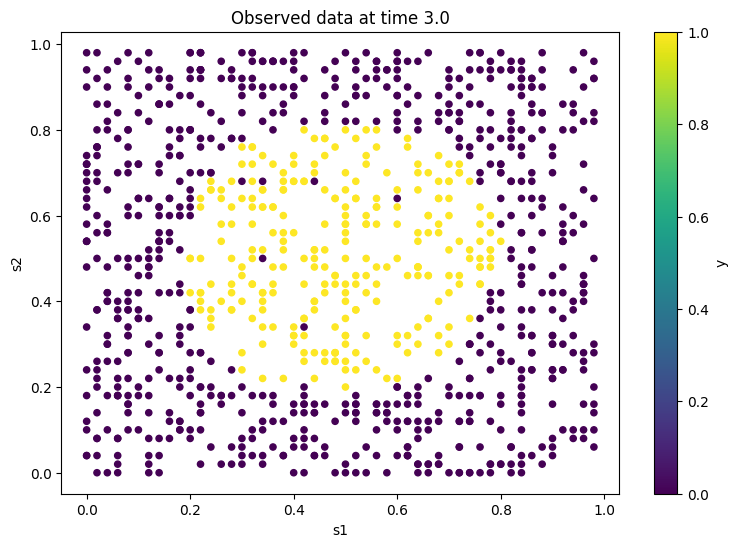

In [ ]:
# Visualize the observed data

df.loc[df.time == times[0]].plot(
    kind="scatter",
    x="s1",
    y="s2",
    c="y",
    title="Observed data at time " + str(np.round(times[0], 2)),
    figsize=(9, 6),
)

df.loc[df.time == times[1]].plot(
    kind="scatter",
    x="s1",
    y="s2",
    c="y",
    title="Observed data at time " + str(np.round(times[1], 2)),
    figsize=(9, 6),
)

df.loc[df.time == times[2]].plot(
    kind="scatter",
    x="s1",
    y="s2",
    c="y",
    title="Observed data at time " + str(np.round(times[2], 2)),
    figsize=(9, 6),
)

df.loc[df.time == times[3]].plot(
    kind="scatter",
    x="s1",
    y="s2",
    c="y",
    title="Observed data at time " + str(np.round(times[3], 2)),
    figsize=(9, 6),
)

df.loc[df.time == times[4]].plot(
    kind="scatter",
    x="s1",
    y="s2",
    c="y",
    title="Observed data at time " + str(np.round(times[4], 2)),
    figsize=(9, 6),
)

df.loc[df.time == times[5]].plot(
    kind="scatter",
    x="s1",
    y="s2",
    c="y",
    title="Observed data at time " + str(np.round(times[5], 2)),
    figsize=(9, 6),
)

In [ ]:
# Define function for boundary condition
def fun_u_b(t, x, y):
    n = x.shape[0]
    return tf.zeros((n, 1), dtype=DTYPE)


# This is a function to simulate a covariate that can be observed in any point in space.
# It is based on a Gaussian kernel.
def covariate_function(x, y):
    intensity = 1.0 / (1.0 + tf.exp(2.0))
    variation = 1.0 / (2.0 * tf.math.pow(0.4, 2.0))
    covar = tf.exp(
        -(tf.math.square(tf.subtract(x, 0.2)) + tf.math.square(tf.subtract(y, 0.2)))
    )
    return intensity * tf.math.pow(covar, variation)


# Define residual for the the physics (PDE)
# in this function u_xx and u_yy are in reality (mu*u)_xx and (mu*u)_yy
def fun_r(model, t, x, y, u, u_t, u_x, u_xx, u_y, u_yy, t0_i=0.0):

    # Get log lambda
    log_lambd_inside = model.gamma0 + model.gamma1 * covariate_function(x, y)

    # Get lambda
    lambd = tf.exp(log_lambd_inside)

    # Get multiply to get lambda*u*(1-u)
    lambd_u = tf.math.multiply(tf.reshape(lambd, [lambd.shape[0], 1]), u)
    logistic_growth_u = tf.math.multiply(lambd_u, 1.0 - u)

    return u_t - u_xx - u_yy - logistic_growth_u


def init_model(num_hidden_layers=4, num_neurons_per_layer=64):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # 3-dimensional input (time + 2 spatial dimension)
    model.add(tf.keras.Input(3))

    # Scaling layer
    scaling_layer = tf.keras.layers.Lambda(lambda x: 2.0 * (x - lb) / (ub - lb) - 1.0)
    model.add(scaling_layer)

    # Hidden layers
    for _ in range(num_hidden_layers):
        model.add(
            tf.keras.layers.Dense(
                num_neurons_per_layer,
                activation=tf.keras.activations.get("tanh"),
                kernel_initializer="glorot_normal",
            )
        )
        # Adjust dropout rate as needed
        model.add(tf.keras.layers.Dropout(0.05))

    # Output layer
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    # Define learnable parameters
    # for log lambda
    model.gamma0 = tf.Variable(0.0, trainable=True, dtype=DTYPE)
    model.gamma1 = tf.Variable(0.0, trainable=True, dtype=DTYPE)

    # for log mu
    model.alpha0 = tf.Variable(0.0, trainable=True, dtype=DTYPE)
    model.alpha1 = tf.Variable(0.0, trainable=True, dtype=DTYPE)

    # for initial condition
    model.kappa0 = tf.Variable(2.0, trainable=True, dtype=DTYPE)
    model.sigma = tf.Variable(0.05, trainable=True, dtype=DTYPE)

    return model


# Auxiliar function to obtain gradients
def get_r(model, X_r, t0_i=0.0):
    # A tf.GradientTape is used to compute derivatives
    with tf.GradientTape(persistent=True) as tape:
        # Get time and space
        t, x, y = X_r[:, 0:1], X_r[:, 1:2], X_r[:, 2:3]

        # Variables t, x and y are watched during tape
        # to compute derivatives
        tape.watch(t)
        tape.watch(x)
        tape.watch(y)

        # Determine residual
        u = model(tf.stack([t[:, 0], x[:, 0], y[:, 0]], axis=1))

        # Define log_mu function using spatial covariate
        log_mu_inside = model.alpha0 + model.alpha1 * covariate_function(x, y)

        # Get mu
        mu = tf.exp(log_mu_inside)

        # Multiply by u
        mu_u = tf.math.multiply(tf.reshape(mu, [mu.shape[0], 1]), u)

        # Compute gradient (mu*u)_x and (mu*u)_y within the GradientTape
        # note that we need second derivatives
        u_x = tape.gradient(mu_u, x)
        u_y = tape.gradient(mu_u, y)

    # Compute gradient (mu*u)_xx and (mu*u)_yy
    u_t = tape.gradient(u, t)
    u_xx = tape.gradient(u_x, x)
    u_yy = tape.gradient(u_y, y)

    del tape

    return fun_r(model, t, x, y, u, u_t, u_x, u_xx, u_y, u_yy, t0_i=t0_i)


tfd = tfp.distributions


# Likelihood function
def m_log_likelihood(data, pre_probs):
    # To avoid taking log of 0
    pre_probs = tf.where(pre_probs < 1e-7, 1e-7, pre_probs)
    pre_probs = tf.where(pre_probs > 1 - 1e-7, 1 - 1e-7, pre_probs)

    # Each entry represents an independet bernoulli input
    dist = tfd.Bernoulli(probs=pre_probs)

    return -tf.reduce_sum(dist.log_prob(data))


# Loss function
def compute_loss(model, X_r, X_data, u_data, t0_i=0.0, eta=1.0):

    # Compute loss associated to physics
    r = get_r(model, X_r, t0_i=t0_i)
    phi_r = tf.reduce_mean(tf.square(r))

    # Initialize loss
    loss = phi_r

    # Add loss for initial condition
    initial_prev = 1.0 / (1.0 + tf.exp(-model.kappa0))
    initial_variance = 1.0 / (2.0 * tf.math.pow(model.sigma, 2.0))
    u_pred = model(X_data[0])
    loss += eta * m_log_likelihood(
        initial_prev * tf.math.pow(u_data[0], initial_variance), u_pred
    )

    # Add loss for boundary condition
    u_pred = model(X_data[1])
    loss += eta * m_log_likelihood(u_data[1], u_pred)

    # Add loss forobserved data
    u_pred = model(X_data[2])
    loss += eta * m_log_likelihood(u_data[2], u_pred)

    return loss


# Get gradient and loss with respect to trainable variables
def get_grad(model, X_r, X_data, u_data, t0_i=0.0, eta=1.0):
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, u_data, t0_i=t0_i, eta=eta)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

In [ ]:
# This is the code necessary for using scipy optimizer
# based on https://github.com/janblechschmidt/PDEsByNNs


def solve_with_ScipyOptimizer(
    model, X_r, X, u, t0_i=0.0, eta=1.0, monitoring=False, method="L-BFGS-B", **kwargs
):
    """Function to learn using scipy.optimize.minimize.
    We need type conversion since scipy-routine is written in Fortran
    and requires 64-bit instead of 32-bit floats."""

    def get_weight_tensor():
        """This function returns variables of the model
        as 1d tensor and their shapes in lists."""

        weight_list = []
        shape_list = []

        # Loop over variables: weight matrices, bias vectors and parameters
        for v in model.variables:
            shape_list.append(v.shape)
            weight_list.extend(v.numpy().flatten())

        weight_list = tf.convert_to_tensor(weight_list)
        return weight_list, shape_list

    x0, shape_list = get_weight_tensor()

    def set_weight_tensor(weight_list):
        """Function sets weights to variables."""
        idx = 0
        for v in model.variables:
            vs = v.shape

            # Weight matrices
            if len(vs) == 2:
                sw = vs[0] * vs[1]
                new_val = tf.reshape(weight_list[idx : idx + sw], (vs[0], vs[1]))
                idx += sw

            # Bias vectors
            elif len(vs) == 1:
                new_val = weight_list[idx : idx + vs[0]]
                idx += vs[0]

            # Other Variables (for parameter identification)
            elif len(vs) == 0:
                new_val = weight_list[idx]
                idx += 1

            # Assign variables
            v.assign(tf.cast(new_val, DTYPE))

    def get_loss_and_grad(w):
        """Function provides current loss and gradient
        with respect to trainable variables.
        NEcessary for LBFGS minimizer in scipy."""

        # Update weights
        set_weight_tensor(w)

        # Determine loss and gradient
        loss, grad = get_grad(model, X_r, X, u, t0_i=t0_i, eta=eta)

        # Store current loss for callback function
        loss = loss.numpy().astype(np.float64)
        model.current_loss = loss

        # Flatten gradient
        grad_flat = []
        for g in grad:
            grad_flat.extend(g.numpy().flatten())

        # Change gradient list to numpy array
        grad_flat = np.array(grad_flat, dtype=np.float64)

        # Return loss value and gradient
        return loss, grad_flat

    # Function to obtain gradients for PDE residual
    # (for annealing algorithm for eta)
    def get_grad_pde(model, X_r, t0_i=0.0):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(model.trainable_variables)

            # Compute grad with respect physics
            r = get_r(model, X_r, t0_i=t0_i)
            loss = tf.reduce_mean(tf.square(r))

        g = tape.gradient(loss, model.trainable_variables)
        del tape

        return g

    # Function to obtain gracients for data residual
    # (for annealing algorithm for eta)
    def get_grad_data(model, X_data, u_data, t0_i=0.0):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(model.trainable_variables)

            # initialize loss
            loss = 0.0

            # initial condition
            initial_prev = 1.0 / (1.0 + tf.exp(-model.kappa0))
            initial_variance = 1.0 / (2.0 * tf.math.pow(model.sigma, 2.0))
            u_pred = model(X_data[0])
            loss += m_log_likelihood(
                initial_prev * tf.math.pow(u_data[0], initial_variance), u_pred
            )

            # boundary condition
            u_pred = model(X_data[1])
            loss += m_log_likelihood(u_data[1], u_pred)

            # observed data
            u_pred = model(X_data[2])
            loss += m_log_likelihood(u_data[2], u_pred)

        g = tape.gradient(loss, model.trainable_variables)
        del tape

        return g

    # Initialize iteartion number for callback and monitoring flag
    itera = 0
    monitoring = monitoring

    # This the callback
    def callback(xr=None):
        global itera, eta, monitoring

        # to check parameters if monitoring
        gamma0 = model.gamma0.numpy()
        gamma1 = model.gamma1.numpy()
        alpha0 = model.alpha0.numpy()
        alpha1 = model.alpha1.numpy()
        kappa0 = model.kappa0.numpy()
        sigma = np.abs(model.sigma.numpy())

        # check loss
        cur_loss = model.current_loss

        # update eta balancing rate every eta_freq iterations
        # (annealing algorithm)
        # can be turned off if we set eta = 1.0 everywhere
        eta_freq = 20
        if itera % eta_freq == 0:
            grad_data = get_grad_data(model, X_data, u_data, t0_i=t0_i)
            mean_grad_data = tf.reduce_mean(
                tf.concat(
                    [tf.math.abs(tf.reshape(s, [-1])) for s in grad_data if s != None],
                    axis=0,
                )
            )
            grad_pde = get_grad_pde(model, X_r, t0_i=t0_i)[:-2]
            max_grad_pde = tf.reduce_max(
                tf.concat([tf.math.abs(tf.reshape(s, [-1])) for s in grad_pde], axis=0)
            )
            eta = (1.0 - 0.9) * eta + 0.9 * max_grad_pde / mean_grad_data

        # If want to monitor training
        if monitoring:
            if itera % 50 == 0:
                print(
                    itera,
                    eta.numpy(),
                    cur_loss,
                    sigma,
                    kappa0,
                    alpha0,
                    alpha1,
                    gamma0,
                    gamma1,
                )

        # eta0.numpy(),
        hist.append(model.current_loss)
        itera += 1

    return scipy.optimize.minimize(
        fun=get_loss_and_grad,
        x0=x0,
        jac=True,
        method=method,
        callback=callback,
        **kwargs
    )


# Function to split data for sequence-to-sequence training
def make_X_data(X_r, X_data, u_data, init=True):
    trh = X_r[X_r.shape[0] - 1][0].numpy()

    ddata_1 = pd.DataFrame(X_data[1].numpy())
    indxs = ddata_1[0] < trh
    ddata_1 = ddata_1[indxs]
    udata_1 = pd.DataFrame(u_data[1].numpy())
    udata_1 = udata_1[indxs]
    ddata_1 = np.array(ddata_1)
    udata_1 = np.array(udata_1)
    ddata_1 = tf.convert_to_tensor(ddata_1)
    udata_1 = tf.convert_to_tensor(udata_1)

    ddata_2 = pd.DataFrame(X_data[2].numpy())
    indxs = ddata_2[0] < trh
    ddata_2 = ddata_2[indxs]
    udata_2 = pd.DataFrame(u_data[2].numpy())
    udata_2 = udata_2[indxs]
    ddata_2 = np.array(ddata_2)
    udata_2 = np.array(udata_2)
    ddata_2 = tf.convert_to_tensor(ddata_2)
    udata_2 = tf.convert_to_tensor(udata_2)

    if init == True:
        X_data_n = [X_data[0], ddata_1, ddata_2]
        u_data_n = [u_data[0], udata_1, udata_2]
        return X_data_n, u_data_n

    else:
        X_data_n = [ddata_1, ddata_2]
        u_data_n = [udata_1, udata_2]
        return X_data_n, u_data_n

In [ ]:
# Determine the number of runs
number_runs = 1

# Initialize some lists to capture results
times = []
gamma0_list = []
gamma1_list = []
alpha0_list = []
alpha1_list = []
kappa0_list = []
sigma_list = []
roc_auc_list = []
pr_auc_list = []

for se in range(number_runs):

    # print("-----------------------------------")

    # Set random seed for reproducible results
    tf.random.set_seed(24)

    # Initial eta
    eta = 1.0

    # Location of initial condition
    s1_0 = 0.5
    s2_0 = 0.5
    # If we have options we can use this:
    # s1_0 = float(np.random.choice(s1_0_options, 1))
    # s2_0 = float(np.random.choice(s2_0_options, 1))

    # Time until first detection
    t0_i = 0.0
    # If we have options we can use this:
    # t0_i = float(np.random.choice(t0_options, 1))

    # Define initial condition
    def fun_u_0(x, y):
        sol = tf.exp(
            -(
                tf.math.square(tf.subtract(x, s1_0))
                + tf.math.square(tf.subtract(y, s2_0))
            )
        )
        return tf.cast(sol, dtype=DTYPE)

    # Introduce lag in time (if any)
    df.time = df.time + t0_i

    # Set boundary constrains
    tmin = 0.0
    tmax = max(df.time)

    xmin = 0.0
    xmax = 1.0

    ymin = 0.0
    ymax = 1.0

    # Lower bounds
    lb = tf.constant([tmin, xmin, ymin], dtype=DTYPE)

    # Upper bounds
    ub = tf.constant([tmax, xmax, ymax], dtype=DTYPE)

    # Set number of boundary data points
    N_b = 500

    # Sampled boundary data
    t_b = tf.random.uniform((N_b, 1), lb[0], ub[0], dtype=DTYPE)
    x1_b = tf.keras.backend.random_uniform(
        (N_b // 4, 1), minval=0.0, maxval=1.0, dtype=DTYPE
    )
    x2_b = tf.keras.backend.random_uniform(
        (N_b // 4, 1), minval=0.0, maxval=1.0, dtype=DTYPE
    )
    x_b = tf.concat(
        [
            x1_b,
            lb[1] * tf.ones((N_b // 4, 1), dtype=DTYPE),
            x2_b,
            ub[1] * tf.ones((N_b // 4, 1), dtype=DTYPE),
        ],
        0,
    )
    y1_b = tf.keras.backend.random_uniform(
        (N_b // 4, 1), minval=0.0, maxval=1.0, dtype=DTYPE
    )
    y2_b = tf.keras.backend.random_uniform(
        (N_b // 4, 1), minval=0.0, maxval=1.0, dtype=DTYPE
    )
    y_b = tf.concat(
        [
            lb[2] * tf.ones((N_b // 4, 1), dtype=DTYPE),
            y1_b,
            ub[2] * tf.ones((N_b // 4, 1), dtype=DTYPE),
            y2_b,
        ],
        0,
    )
    X_b = tf.concat([t_b, x_b, y_b], axis=1)
    # Evaluate boundary condition at sample data
    u_b = fun_u_b(t_b, x_b, y_b)

    # Observed points (real data)
    t_d = tf.reshape(tf.cast(df.time, dtype=DTYPE), [df.shape[0], 1])
    x_d = tf.reshape(tf.cast(df.s1, dtype=DTYPE), [df.shape[0], 1])
    y_d = tf.reshape(tf.cast(df.s2, dtype=DTYPE), [df.shape[0], 1])
    X_d = tf.concat([t_d, x_d, y_d], axis=1)
    u_d = tf.cast(df.y, dtype=DTYPE)

    # Set number of initial data points
    N_0 = 1000

    # Draw uniform sample points for initial data
    t_0 = tf.ones((N_0, 1), dtype=DTYPE) * lb[0]
    x_0 = tf.concat(
        [
            tf.random.uniform((N_0 - 1, 1), lb[1], ub[1], dtype=DTYPE),
            s1_0 * tf.ones((1, 1), dtype=DTYPE),
        ],
        0,
    )
    y_0 = tf.concat(
        [
            tf.random.uniform((N_0 - 1, 1), lb[2], ub[2], dtype=DTYPE),
            s2_0 * tf.ones((1, 1), dtype=DTYPE),
        ],
        0,
    )
    X_0 = tf.concat([t_0, x_0, y_0], axis=1)

    # Evaluate intitial condition
    u_0 = fun_u_0(x_0, y_0)

    # Set number of colocation points
    N_r = int((tmax + 1) * 500)

    # Draw uniformly sampled collocation points
    t_r = tf.random.uniform((N_r, 1), lb[0], ub[0], dtype=DTYPE)
    t_r = tf.sort(t_r, axis=0)
    x_r = tf.random.uniform((N_r, 1), lb[1], ub[1], dtype=DTYPE)
    y_r = tf.random.uniform((N_r, 1), lb[2], ub[2], dtype=DTYPE)
    X_r = tf.concat([t_r, x_r, y_r], axis=1)

    # Collect inital, boundary and observed data in lists
    X_data = [X_0, X_b, X_d]
    u_data = [u_0, u_b, u_d]

    # Define history
    hist = []

    # Initialize neural network model
    model = init_model()
    model.build(input_shape=(None, 3))

    # Initialize history of losses and global iteration counter
    itera = 0

    # Start timer
    t0 = time()

    monitoring = False

    # number of divisions for sequence-to-sequence traning mode. For example use 3
    divisions = 2
    X_r1, X_r2 = tf.split(X_r, num_or_size_splits=divisions, axis=0)
    list_data = [X_r1, X_r2]
    for k in range(divisions):
        X_data_current, u_data_current = make_X_data(
            list_data[k], X_data, u_data, init=True
        )
        solve_with_ScipyOptimizer(
            model,
            list_data[k],
            X_data_current,
            u_data_current,
            t0_i=t0_i,
            eta=eta,
            monitoring=monitoring,
            method="L-BFGS-B",
            options={
                "maxiter": 200,
                "maxfun": 200,
                "maxcor": 100,
                "maxls": 100,
                "ftol": 1.0 * np.finfo(float).eps,
            },
        )
        # print("Finishing batch number: ", k + 1)

    # print("\nComputation time: {} minutes".format((time() - t0) / 60.0))
    # print("\n or: {} hours".format((time() - t0) / 3600.0))

    times.append(time() - t0)

    gamma0_list.append(model.gamma0.numpy())
    gamma1_list.append(model.gamma1.numpy())

    alpha0_list.append(model.alpha0.numpy())
    alpha1_list.append(model.alpha1.numpy())

    kappa0_list.append(model.kappa0.numpy())
    sigma_list.append(np.abs(model.sigma.numpy()))

    # metrics
    upred_train = model(tf.cast(X_d, DTYPE))
    auc_roc_train = roc_auc_score(u_d.numpy(), upred_train)
    roc_auc_list.append(auc_roc_train)
    # print("\n ROC-AUC = ", auc_roc_train)

    precision, recall, thresholds = precision_recall_curve(u_d.numpy(), upred_train)
    auc_precision_recall_train = auc(recall, precision)
    pr_auc_list.append(auc_precision_recall_train)
    # print("\n Precision_Recall-AUC = ", auc_precision_recall_train)

In [ ]:
# transform kappa to initial prevalence for interpretation
initial_prev_res = [1.0 / (1.0 + np.exp(-item)) for item in kappa0_list]

results = {
    "time": times,
    "gamma0": gamma0_list,
    "gamma1": gamma1_list,
    "alpha0": alpha0_list,
    "alpha1": alpha1_list,
    "initial_prev": initial_prev_res,
    "sigma": sigma_list,
}

df_results = pd.DataFrame(results)

In [ ]:
df_results.describe()

time     gamma0     gamma1     alpha0     alpha1  initial_prev  \
count  50.000000  50.000000  50.000000  50.000000  50.000000     50.000000   
mean   92.538008  -0.016966  -0.001389 -15.135760  -0.994076      0.925192   
std     9.432968   0.352179   0.023044   3.812726   0.275585      0.018928   
min    50.147608  -1.202264  -0.081534 -24.272499  -1.672249      0.875519   
25%    93.762342   0.015540  -0.000047 -17.325412  -1.151919      0.912974   
50%    94.861858   0.061073   0.003134 -14.707089  -0.965554      0.928867   
75%    95.888956   0.080606   0.005459 -12.389358  -0.837737      0.939715   
max    98.765340   0.811205   0.041847  -8.989480  -0.437285      0.952966   

           sigma  
count  50.000000  
mean    0.072520  
std     0.039804  
min     0.001582  
25%     0.069533  
50%     0.074070  
75%     0.077762  
max     0.297186

In [ ]:
# Real parameters for mu and lambda
real_alpha0 = -10.0
real_alpha1 = -1.0

real_gamma0 = 0.1
real_gamma1 = 0.01

# Real parameters for initial condition
real_init_inten = 1.0 / (1.0 + tf.exp(-3.0))
real_init_vari = 0.10

In [ ]:
# Computing relative erros
print("Relative error for alpha 0")

np.round(np.abs((df_results["alpha0"].median() - real_alpha0) / real_alpha0), 3)

Relative error for alpha 0


0.471

In [ ]:
print("Relative error for alpha 1")

np.round(np.abs((df_results["alpha1"].median() - real_alpha1) / real_alpha1), 3)

Relative error for alpha 1


0.034

In [ ]:
print("Relative error for gamma 0")

np.round(np.abs((df_results["gamma0"].median() - real_gamma0) / real_gamma0), 3)

Relative error for gamma 0


0.389

In [ ]:
print("Relative error for gamma 1")

np.round(np.abs((df_results["gamma1"].median() - real_gamma1) / real_gamma1), 3)

Relative error for gamma 1


0.687

In [ ]:
print("Relative error for initial maximum prevalence")

np.round(
    np.abs((df_results["initial_prev"].median() - real_init_inten) / real_init_inten), 3
)

Relative error for initial maximum prevalence


0.025

In [ ]:
print("Relative error for initial variance")

np.round(np.abs((df_results["sigma"].median() - real_init_vari) / real_init_vari), 3)

Relative error for initial variance


0.259

### Loss function vs iteration

Text(0, 0.5, 'Loss')

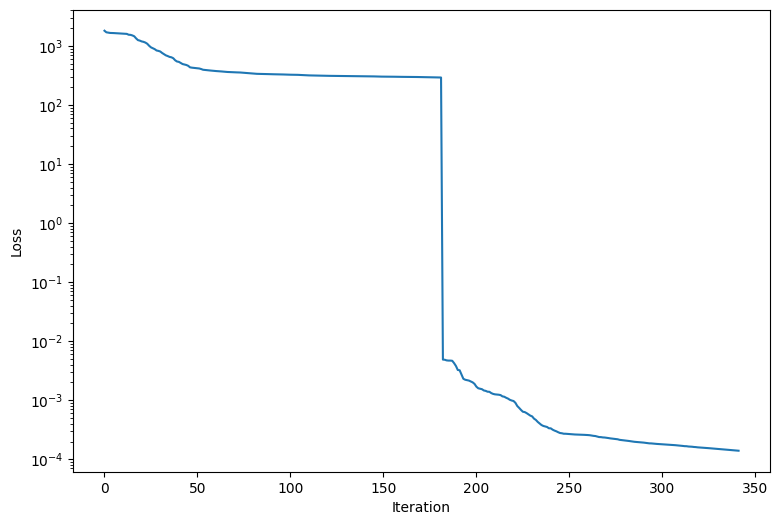

In [ ]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist)
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")

In [ ]:
# Get predictions of solution for data
upred = model(tf.cast(X_d, DTYPE))

### ROC and Precision-Recall curves

In [ ]:
print("Average ROC area under the curve: " + str(np.round(np.mean(roc_auc_list), 3)))

Average ROC area under the curve: 0.939


In [ ]:
print(
    "Average Precision-Recall area under the curve: "
    + str(np.round(np.mean(pr_auc_list), 3))
)

Average Precision-Recall area under the curve: 0.864


#### Curves for one run

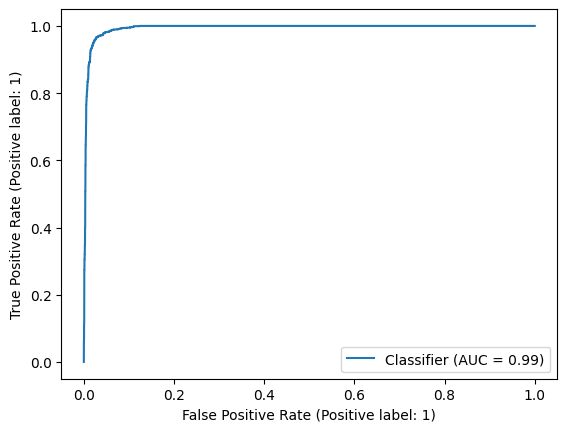

In [ ]:
RocCurveDisplay.from_predictions(u_d.numpy(), upred)

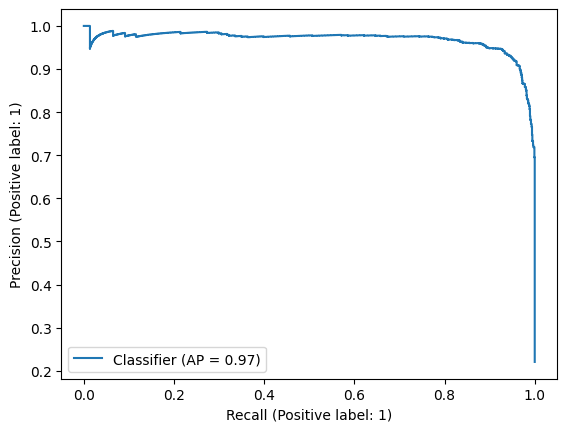

In [ ]:
PrecisionRecallDisplay.from_predictions(u_d.numpy(), (upred))

### Compare approximated solution with training data

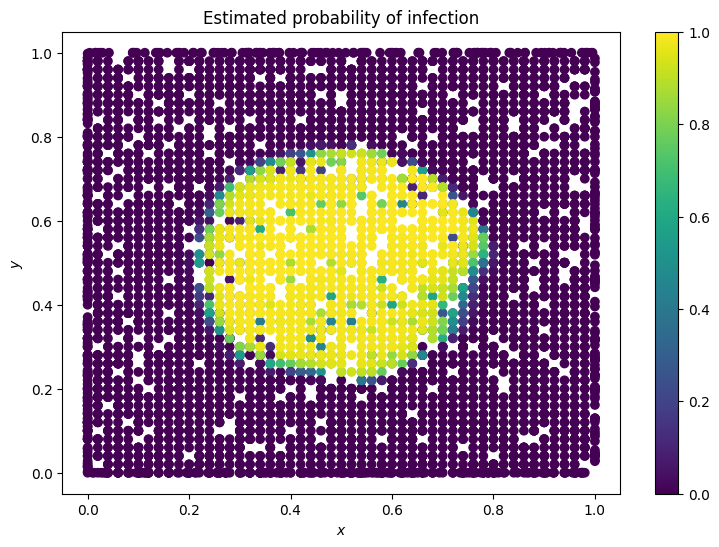

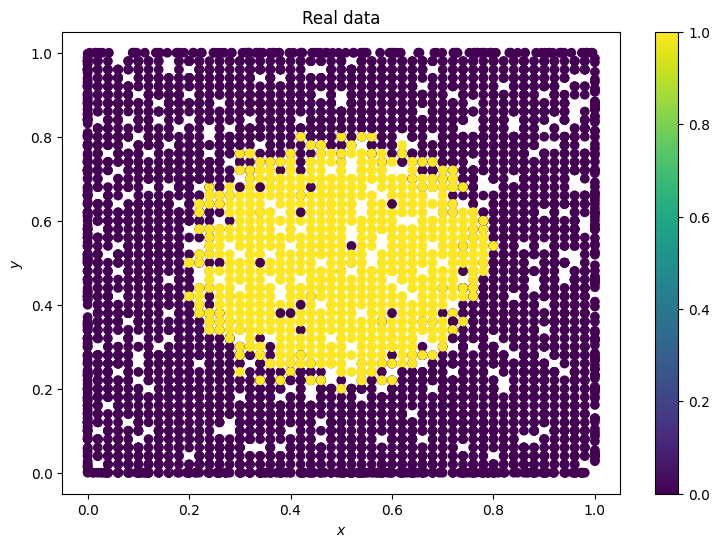

In [ ]:
X0 = X_d[:, 1]
Y0 = X_d[:, 2]
U0 = upred
T0 = X_d[:, 0]

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)

img = ax.scatter(X0, Y0, c=U0, vmin=0, vmax=1)  #
fig.colorbar(img)
img2 = ax.scatter(x_b, y_b, c=u_b, vmin=0, vmax=1)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Estimated probability of infection")
plt.show()


X0 = X_d[:, 1]
Y0 = X_d[:, 2]
U0 = u_d.numpy()
T0 = X_d[:, 0]

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)

img = ax.scatter(X0, Y0, c=U0, vmin=0, vmax=1)
fig.colorbar(img)
img2 = ax.scatter(x_b, y_b, c=u_b, vmin=0, vmax=1)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Real data")
plt.show()

### Visualize approximated solution for different time points

In [ ]:
# Set up a meshgrid 50x50x50
N_t = 50
N_x = N_y = 50
tspace = np.linspace(lb[0], ub[0], N_t + 1)
xspace = np.linspace(lb[1], ub[1], N_x + 1)
yspace = np.linspace(lb[2], ub[2], N_y + 1)
T, X, Y = np.meshgrid(tspace, xspace, yspace)
Xgrid = np.vstack([T.flatten(), X.flatten(), Y.flatten()]).T

# Get predictions of solution
upred = model(tf.cast(Xgrid, DTYPE))

# Reshape solution for plotting
U = upred.numpy().reshape(N_x + 1, N_t + 1, N_y + 1)

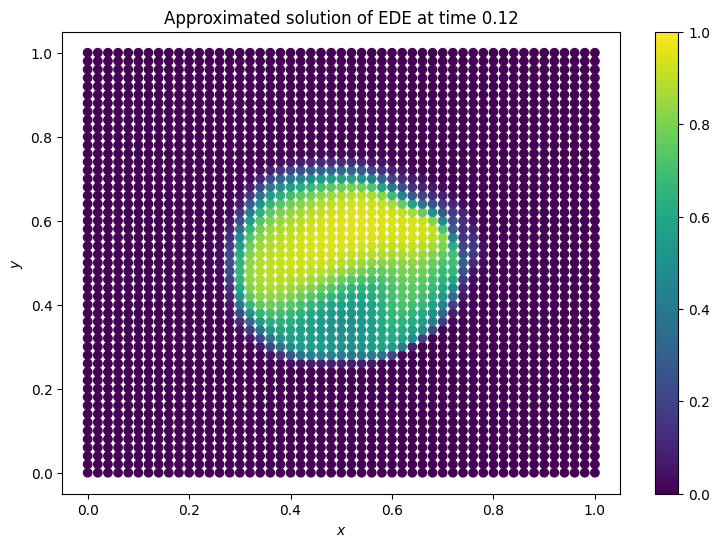

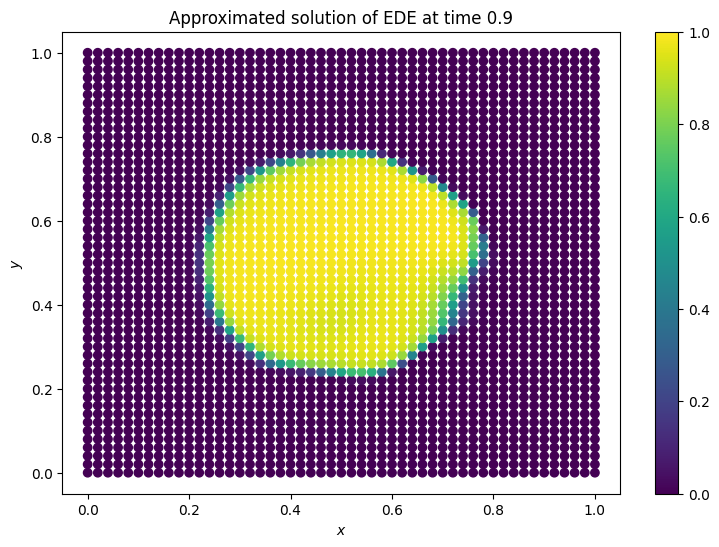

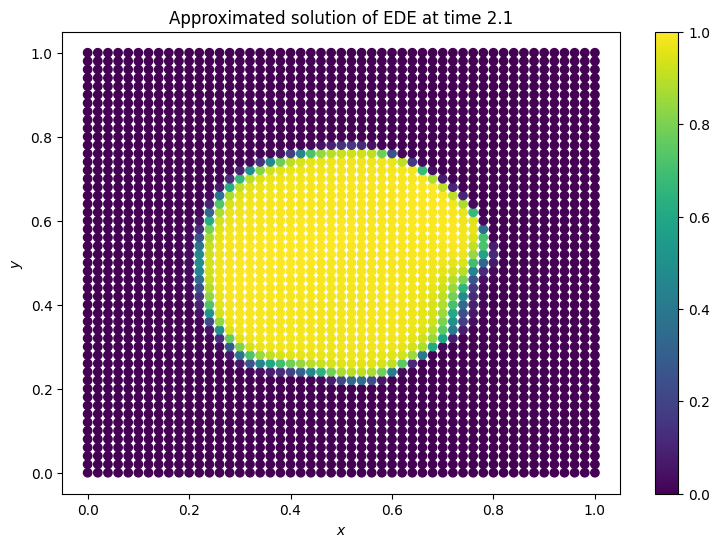

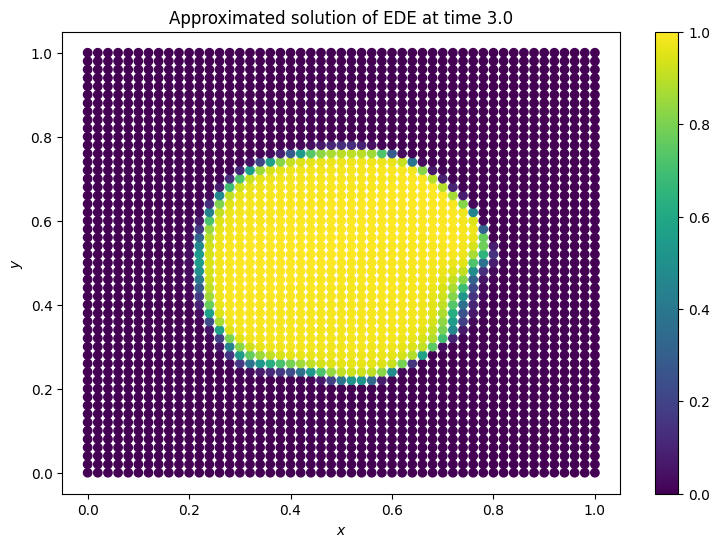

In [ ]:
X0 = [item[2] for item in X]
Y0 = [item[2] for item in Y]
U0 = [item[2] for item in U]

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)

img = ax.scatter(X0, Y0, c=U0, vmin=0, vmax=1)
fig.colorbar(img)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Approximated solution of EDE at time " + str(np.round(T[0][2][0], 2)))
plt.show()


X0 = [item[15] for item in X]
Y0 = [item[15] for item in Y]
U0 = [item[15] for item in U]

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)

img = ax.scatter(X0, Y0, c=U0, vmin=0, vmax=1)
fig.colorbar(img)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Approximated solution of EDE at time " + str(np.round(T[0][15][0], 2)))
plt.show()


X0 = [item[35] for item in X]
Y0 = [item[35] for item in Y]
U0 = [item[35] for item in U]

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)

img = ax.scatter(X0, Y0, c=U0, vmin=0, vmax=1)
fig.colorbar(img)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Approximated solution of EDE at time " + str(np.round(T[0][35][0], 2)))
plt.show()


X0 = [item[50] for item in X]
Y0 = [item[50] for item in Y]
U0 = [item[50] for item in U]

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)

img = ax.scatter(X0, Y0, c=U0, vmin=0, vmax=1)
fig.colorbar(img)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Approximated solution of EDE at time " + str(np.round(T[0][50][0], 2)))
plt.show()

### Visualize approximation for initial condition

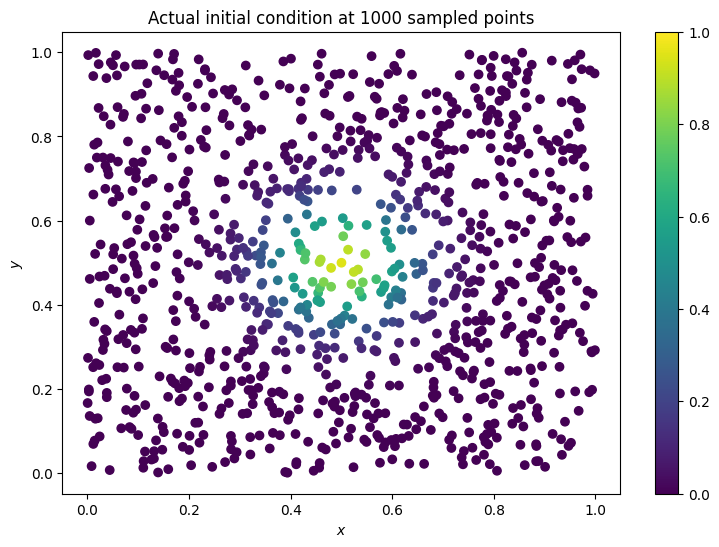

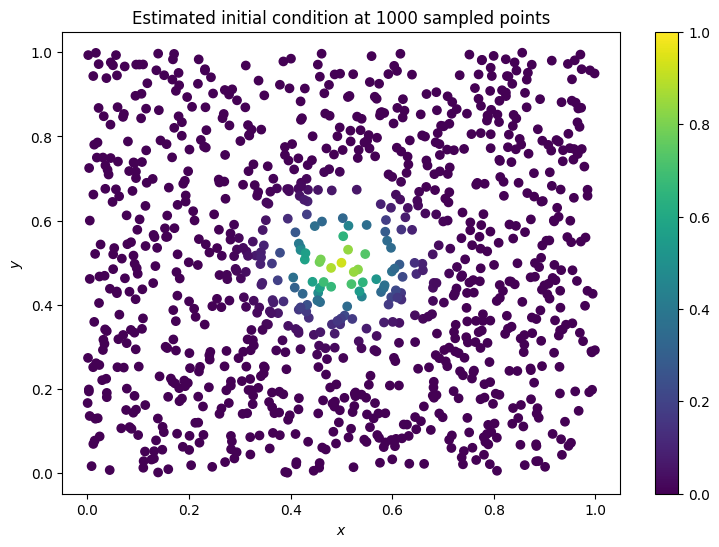

In [ ]:
# Real initial condition
initial_prev = 1.0 / (1.0 + tf.exp(-3.0))
initial_variance = 1.0 / (2.0 * tf.math.pow(0.1, 2.0))

# Take the initial condition sampled points
X0 = X_0[:, 1]
Y0 = X_0[:, 2]
U0 = initial_prev * tf.math.pow(u_0.numpy(), initial_variance)

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)
img = ax.scatter(X0, Y0, c=U0, vmin=0, vmax=1)
fig.colorbar(img)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Actual initial condition at 1000 sampled points")
plt.show()


# Estimated initial conditon
initial_prev = df_results["initial_prev"].median()
initial_variance = 1.0 / (2.0 * tf.math.pow(df_results["sigma"].median(), 2.0))

U0 = initial_prev * tf.math.pow(u_0.numpy(), initial_variance)

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)
img = ax.scatter(X0, Y0, c=U0, vmin=0, vmax=1)
fig.colorbar(img)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Estimated initial condition at 1000 sampled points")
plt.show()